In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import networkx as nx
import tensorflow as tf
import numpy as np
from utils.utils import predict
import matplotlib.pyplot as plt

In [2]:
model_m_to_s = tf.keras.models.load_model("./model/gbif_batch_128_layer_1024_m_to_s", compile=True)
model_s_to_m = tf.keras.models.load_model("./model/gbif_batch_128_layer_1024_s_to_m", compile=True)

In [3]:
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0)
df_agg = pd.read_csv("./data/lotus_agg_test.csv.gz", index_col=0)

In [4]:
rdkit = pd.read_csv("./data/mol_dummy_rdkit.csv.gz", index_col=0).astype('uint8')
rdkit.columns = rdkit.columns.astype(str)

In [5]:
g_train = nx.read_graphml("./graph/train_graph.gml")
g = nx.read_graphml("./graph/test_graph.gml")
g  = nx.create_empty_copy(g)
g_merged = nx.compose(g_train, g)

In [6]:
df_agg_train = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)

In [7]:
g_test = nx.read_graphml("./graph/test_graph.gml")
g_lotus = nx.compose(g_train, g_test)

In [8]:
sku = pd.concat([df_agg, df_agg_train])

In [9]:
sp = 'Trigonostemon reidioides'
data_3 = pd.DataFrame(
    {'molecule': list(set(molecule_features_dummy.index)-set(sku[sku.organism_name==sp].structure_smiles_2D)),
     'species': sp})

In [10]:
data_3

,molecule,species
0,O=C1NC(Cc2ccccc2)C(=O)N2C1CC1(C34CC5C(=O)NC(Cc...,Trigonostemon reidioides
1,C=CC1C(O)CC2C3CCC4C(O)C(O)C(OS(=O)(=O)O)CC4(C)...,Trigonostemon reidioides
2,CC1OC(OC2C(O)CC3(C)C(CCC4(C)C3CC=C3C5C(C(=O)O)...,Trigonostemon reidioides
3,COC(=O)c1ccc(O)c(NC(=O)CCC2(C)C(=O)C=CC34CC5CC...,Trigonostemon reidioides
4,COc1cc(C(C)=CC2(C)OC2C)oc(=O)c1C,Trigonostemon reidioides
...,...,...
147728,CC1=CCC(O)CC(O)CC(O)CC(O)CC(O)CC(O)C(C)C(O)C=C...,Trigonostemon reidioides
147729,CC1(C)CCC2(C(=O)O)CCC3(C)C(CCC4C5(C)CCC(O)C(C)...,Trigonostemon reidioides
147730,CC(CCC1(C)C(C)CCC23COC(=O)C2(O)C=CCC13)CC(=O)O,Trigonostemon reidioides
147731,C=CC(C)(C)OC(C)C1NC(=O)C2CSC(=N2)C(C(C)C)NC(=O...,Trigonostemon reidioides


In [11]:
out_3 = predict(g_lotus,
                model_m_to_s,
                model_s_to_m,
                data_3,
                molecule_features_dummy,
                rdkit,
                species_features_dummy
               )

Converting Inchikeys to SMILES...
Getting missing features...
Converting species taxonomy as numeric...
Converting molecules as numeric...
Checking which model should be used for each row...
Adding missing nodes to the graph...
Converting NetworkX to Stellargraph...
StellarDiGraph: Directed multigraph
 Nodes: 184194, Edges: 869484

 Node types:
  molecule: [147747]
    Features: float32 vector, length 155
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [434742]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [434742]
        Weights: all 1 (default)
        Features: none
Creating 'forward', 'backward' flow for KNOWN molecule AND species...
Predict both : running molecule to species predictions...
145/145 [==============================] - 22s 153ms/step
Predict both : running species to molecules prediction...


(array([3.9387e+04, 1.2812e+04, 6.8780e+03, 4.8430e+03, 3.7730e+03,
        3.1240e+03, 2.5800e+03, 2.3590e+03, 2.1750e+03, 1.8610e+03,
        1.7510e+03, 1.6570e+03, 1.5130e+03, 1.4710e+03, 1.3170e+03,
        1.3220e+03, 1.2280e+03, 1.2050e+03, 1.0920e+03, 1.0560e+03,
        1.0570e+03, 1.0080e+03, 9.6300e+02, 9.1700e+02, 9.2400e+02,
        8.6700e+02, 8.4100e+02, 8.3400e+02, 8.0500e+02, 7.6000e+02,
        8.0600e+02, 7.4300e+02, 7.1500e+02, 7.4400e+02, 7.3100e+02,
        7.3000e+02, 6.4800e+02, 6.5500e+02, 6.6000e+02, 6.5400e+02,
        5.9900e+02, 6.3300e+02, 6.2400e+02, 6.4000e+02, 6.1200e+02,
        5.7700e+02, 6.0400e+02, 5.6000e+02, 5.2300e+02, 5.3200e+02,
        5.4000e+02, 5.4300e+02, 5.2200e+02, 4.6900e+02, 5.2000e+02,
        4.9300e+02, 4.9600e+02, 5.2900e+02, 4.8000e+02, 4.5200e+02,
        4.8500e+02, 4.4200e+02, 4.8400e+02, 4.7900e+02, 4.6200e+02,
        4.4400e+02, 4.3800e+02, 4.2300e+02, 4.3500e+02, 4.3900e+02,
        4.0700e+02, 4.2000e+02, 4.4000e+02, 4.27

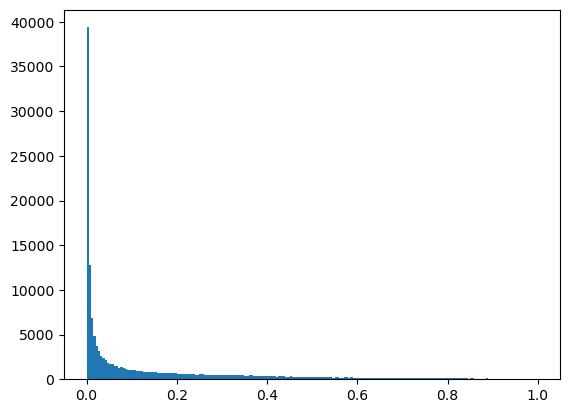

In [12]:
plt.hist(out_3.prob, bins=200)

In [13]:
out_3[out_3.prob>0.95]

,molecule,species,model,prob
263,C=C(C)C1CCC2(C=O)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(...,Trigonostemon reidioides,both_known,0.976842
409,O=C(O)c1ccc(O)c(O)c1O,Trigonostemon reidioides,both_known,0.969063
564,COc1cc2c(cc1C(C)C)CCC1C3=C(CCC21C)C(=O)OC(C)(C...,Trigonostemon reidioides,both_known,0.974157
1635,CC1=C2C3OC34CCC3C(C)(C)CCCC3(C)C4C3OC23OC1=O,Trigonostemon reidioides,both_known,0.965824
2555,CC(C)=CCc1c(O)cc(C=Cc2cc(O)c3c(c2)CC2C(C)(CCC(...,Trigonostemon reidioides,both_known,0.959104
...,...,...,...,...
145078,CC1C(O)CCC2C1(C)CCC1C2(C)CCC2(C)C3CC(C)(C)CCC3...,Trigonostemon reidioides,both_known,0.994295
145318,C=C1C(CO)CCC2(C)c3ccc(C(C)C)c(O)c3CCC12,Trigonostemon reidioides,both_known,0.973424
145589,COc1cc(C=CC(=O)OC2CC(O)(C(=O)O)CC(O)C2O)ccc1O,Trigonostemon reidioides,both_known,0.957319
146304,C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(=O)C(C)(C...,Trigonostemon reidioides,both_known,0.952410


# Test 4: let's see if cholesterol is present "everywhere"


In [14]:
mol = 'CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C'
data_4 = pd.DataFrame(
    {'molecule': mol,
     'species': list(set(species_features_dummy.index)-set(sku[sku.structure_smiles_2D==mol].organism_name))})

In [15]:
out_4 = predict(g_lotus,
                model_m_to_s,
                model_s_to_m,
                data_4,
                molecule_features_dummy,
                rdkit,
                species_features_dummy
               )

Converting Inchikeys to SMILES...
Getting missing features...
Converting species taxonomy as numeric...
Converting molecules as numeric...
Checking which model should be used for each row...
Adding missing nodes to the graph...
Converting NetworkX to Stellargraph...
StellarDiGraph: Directed multigraph
 Nodes: 184194, Edges: 869484

 Node types:
  molecule: [147747]
    Features: float32 vector, length 155
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [434742]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [434742]
        Weights: all 1 (default)
        Features: none
Creating 'forward', 'backward' flow for KNOWN molecule AND species...
Predict both : running molecule to species predictions...
36/36 [==============================] - 7s 197ms/step
Predict both : running species to molecules prediction...
36/

(array([2.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 3.000e+00,
        4.000e+00, 6.000e+00, 5.000e+00, 5.000e+00, 5.000e+00, 5.000e+00,
        4.000e+00, 1.400e+01, 4.000e+00, 1.000e+01, 9.000e+00, 9.000e+00,
        1.100e+01, 1.400e+01, 1.200e+01, 1.100e+01, 1.700e+01, 8.000e+00,
        9.000e+00, 1.500e+01, 1.200e+01, 6.000e+00, 9.000e+00, 6.000e+00,
        1.400e+01, 1.100e+01, 1.300e+01, 2.000e+01, 1.200e+01, 1.000e+01,
        1.000e+01, 1.900e+01, 1.400e+01, 1.200e+01, 1.600e+01, 1.800e+01,
        1.900e+01, 1.800e+01, 2.100e+01, 1.600e+01, 1.700e+01, 3.500e+01,
        2.500e+01, 2.200e+01, 3.000e+01, 4.000e+01, 2.900e+01, 2.700e+01,
        2.100e+01, 2.500e+01, 3.200e+01, 2.800e+01, 2.400e+01, 3.300e+01,
        4.000e+01, 4.000e+01, 4.300e+01, 4.700e+01, 5.100e+01, 4.700e+01,
        4.200e+01, 4.000e+01, 5.200e+01, 4.300e+01, 4.800e+01, 5.100e+01,
        5.000e+01, 5.300e+01, 6.100e+01, 5.600e+01, 5.600e+01, 5.300e+01,
        7.100e+01, 7.800e+01, 7.800e+0

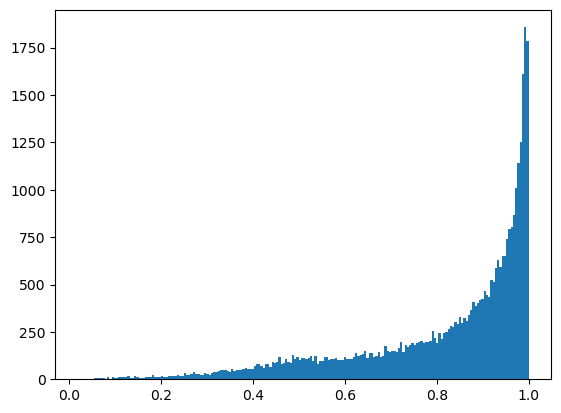

In [16]:
plt.hist(out_4.prob, bins=200)

In [17]:
out_4[out_4.prob>0.99]

,molecule,species,model,prob
7,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Helianthus,both_known,0.993567
9,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Chroodactylon ornatum,both_known,0.993574
11,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Salvia iodantha,both_known,0.997976
12,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Ruscus aculeatus,both_known,0.997258
31,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Scleroderma polyrhizum,both_known,0.998064
...,...,...,...,...
35866,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Laennecia filaginoides,both_known,0.991661
35877,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Eucalyptus camaldulensis,both_known,0.998770
35882,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Lagenidium callinectes,both_known,0.994594
35892,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Stemodia durantifolia,both_known,0.995778


# Test 5: test with a more rare molecule : Erythromycin

In [18]:
mol = 'CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)(O)CC(C)C(=O)C(C)C(O)C1(C)O'
data_5 = pd.DataFrame(
    {'molecule': mol,
     'species': list(set(species_features_dummy.index)-set(sku[sku.structure_smiles_2D==mol].organism_name))}
)

In [19]:
out_5 = predict(g_lotus,
                model_m_to_s,
                model_s_to_m,
                data_5,
                molecule_features_dummy,
                rdkit,
                species_features_dummy
               )

Converting Inchikeys to SMILES...
Getting missing features...
Converting species taxonomy as numeric...
Converting molecules as numeric...
Checking which model should be used for each row...
Adding missing nodes to the graph...
Converting NetworkX to Stellargraph...
StellarDiGraph: Directed multigraph
 Nodes: 184194, Edges: 869484

 Node types:
  molecule: [147747]
    Features: float32 vector, length 155
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [434742]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [434742]
        Weights: all 1 (default)
        Features: none
Creating 'forward', 'backward' flow for KNOWN molecule AND species...
Predict both : running molecule to species predictions...
36/36 [==============================] - 6s 168ms/step
Predict both : running species to molecules prediction...
36/

(array([2.7083e+04, 2.2340e+03, 1.0570e+03, 6.7500e+02, 4.8000e+02,
        3.6100e+02, 3.2900e+02, 2.1900e+02, 2.3200e+02, 1.7400e+02,
        1.7300e+02, 1.5500e+02, 1.1700e+02, 1.0100e+02, 1.1200e+02,
        9.8000e+01, 9.1000e+01, 8.8000e+01, 8.6000e+01, 7.4000e+01,
        7.9000e+01, 6.0000e+01, 7.2000e+01, 5.3000e+01, 5.8000e+01,
        5.8000e+01, 5.1000e+01, 4.2000e+01, 3.0000e+01, 4.3000e+01,
        3.9000e+01, 4.3000e+01, 3.7000e+01, 3.6000e+01, 3.4000e+01,
        3.8000e+01, 3.2000e+01, 3.2000e+01, 3.5000e+01, 2.9000e+01,
        3.0000e+01, 2.9000e+01, 2.5000e+01, 2.5000e+01, 1.9000e+01,
        2.5000e+01, 2.9000e+01, 3.2000e+01, 2.2000e+01, 2.0000e+01,
        2.8000e+01, 1.4000e+01, 2.3000e+01, 2.4000e+01, 1.8000e+01,
        1.5000e+01, 1.9000e+01, 3.2000e+01, 1.1000e+01, 1.0000e+01,
        2.1000e+01, 1.8000e+01, 1.0000e+01, 7.0000e+00, 1.5000e+01,
        1.2000e+01, 1.4000e+01, 1.1000e+01, 4.0000e+00, 8.0000e+00,
        1.1000e+01, 1.1000e+01, 1.5000e+01, 1.40

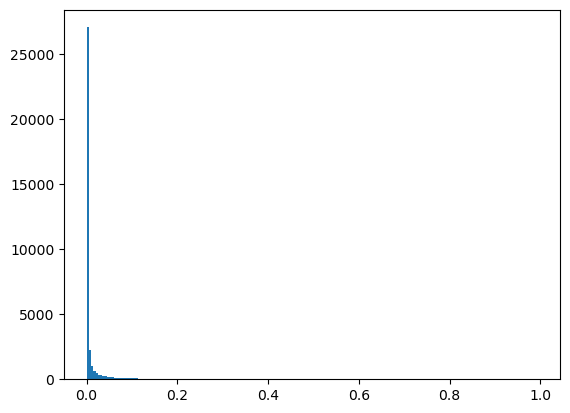

In [20]:
plt.hist(out_5.prob, bins=200)

In [21]:
out_5[out_5.prob>0.95]

,molecule,species,model,prob
44,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces diastatochromogenes,both_known,0.989459
321,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces bellus,both_known,0.951114
323,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces alanosinicus,both_known,0.960570
371,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces shiodaensis,both_known,0.955724
624,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Nocardioides,both_known,0.972674
...,...,...,...,...
34955,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces spectabilis,both_known,0.973104
35670,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces noursei,both_known,0.972929
35729,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces lohii,both_known,0.987470
35900,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces bernensis,both_known,0.972440


# Test adding just one edge to an unkown molecule to see the difference

In [22]:
mol = 'CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C'
data_6 = pd.DataFrame(
    {'molecule': mol,
     'species': list(set(species_features_dummy.index)-set(sku[sku.structure_smiles_2D==mol].organism_name))})

In [23]:
g_lotus.add_node('CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C', label='molecule')
g_lotus.add_edge('CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C', 'Mus musculus', label='present_in')
g_lotus.add_edge('Mus musculus','CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C', label='has')
g_lotus.add_edge('CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C', 'Dicranum japonicum', label='present_in')
g_lotus.add_edge( 'Dicranum japonicum', 'CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C', label='has')
g_lotus.add_edge('CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C', 'Streptomyces atratus', label='present_in')
g_lotus.add_edge('Streptomyces atratus','CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C', label='has')
g_lotus.add_edge('CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C','Campylopus richardii', label='present_in')
g_lotus.add_edge('Campylopus richardii','CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C', label='has')
g_lotus.add_edge('CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C','Suaeda aegyptiaca', label='present_in')
g_lotus.add_edge('Suaeda aegyptiaca','CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C', label='has')

In [24]:
from utils.molecules import smiles_to_classyfire, smiles_to_fingerprint

In [25]:
chol_classy = smiles_to_classyfire(['CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C'])

In [26]:
chol_fp = smiles_to_fingerprint(['CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C'])
chol_fp.columns  = chol_fp.columns.astype(str)

In [27]:
out_6 = predict(g_lotus,
                model_m_to_s,
                model_s_to_m,
                data_6,
                pd.concat([molecule_features_dummy, chol_classy]),
                pd.concat([rdkit, chol_fp]),
                species_features_dummy
               )

Converting Inchikeys to SMILES...
Getting missing features...
Converting species taxonomy as numeric...
Converting molecules as numeric...
Checking which model should be used for each row...
Adding missing nodes to the graph...
Converting NetworkX to Stellargraph...
StellarDiGraph: Directed multigraph
 Nodes: 184195, Edges: 869494

 Node types:
  molecule: [147748]
    Features: float32 vector, length 155
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [434747]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [434747]
        Weights: all 1 (default)
        Features: none
Creating 'forward', 'backward' flow for KNOWN molecule AND species...
Predict both : running molecule to species predictions...
36/36 [==============================] - 5s 147ms/step
Predict both : running species to molecules prediction...
36/

(array([  9.,  28.,  21.,  23.,  22.,  32.,  25.,  21.,  26.,  15.,  23.,
         20.,  21.,  24.,  32.,  28.,  35.,  29.,  29.,  36.,  41.,  42.,
         46.,  54.,  53.,  50.,  54.,  58.,  63.,  55.,  62.,  74.,  72.,
         80.,  89.,  74.,  80.,  74.,  80.,  90.,  88.,  64., 103.,  80.,
         88.,  91.,  86.,  82.,  92., 115., 104.,  88.,  98.,  87., 104.,
        101., 106.,  87.,  95., 106., 131.,  95.,  87., 102., 101., 125.,
        109., 127., 122., 128., 140., 135., 126., 121., 112., 136., 129.,
        133., 144., 121., 119., 119., 136., 141., 140., 120., 113., 147.,
        163., 145., 137., 142., 134., 139., 137., 138., 147., 132., 150.,
        116., 177., 158., 145., 150., 163., 142., 174., 157., 156., 155.,
        190., 181., 169., 174., 163., 199., 192., 190., 169., 167., 150.,
        195., 206., 197., 192., 231., 207., 208., 191., 220., 218., 225.,
        228., 254., 211., 240., 206., 241., 250., 270., 214., 237., 269.,
        235., 239., 310., 273., 296., 

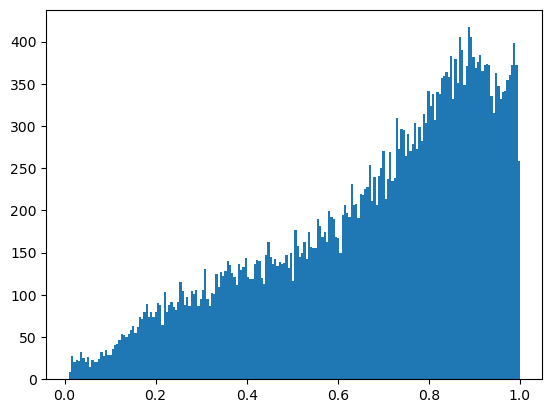

In [28]:
plt.hist(out_6.prob, bins=200)

In [29]:
out_6[out_6.prob>0.99]

,molecule,species,model,prob
9,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Chroodactylon ornatum,both_known,0.991802
31,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Scleroderma polyrhizum,both_known,0.994023
106,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Lymnaea stagnalis,both_known,0.994955
118,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Langermannia,both_known,0.991967
143,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Chiton tuberculatus,both_known,0.996320
...,...,...,...,...
36277,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Leishmania mexicana,both_known,0.998715
36309,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Ophioplocus japonicus,both_known,0.995314
36344,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Codium latum,both_known,0.992666
36356,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Graesiella emersonii,both_known,0.992510
